##QUANTUM WALKS!

###Installations and Imports

In [8]:
#In case you don't have qiskit, install it now
%pip install qiskit --quiet
%pip install qiskit-aer --quiet
#Installing/upgrading pylatexenc seems to have fixed my mpl issue
#If you try this and it doesn't work, try also restarting the runtime/kernel
%pip install pylatexenc --quiet

In [9]:
#Let's go ahead and import all this stuff too
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.quantum_info import Statevector
import numpy as np
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import math
import random

In [10]:
def myQFT(qc,n):
  for i in range(n):
    l = (n-1)-i
    qc.h(l)
    #print("H",l) #For tracking the behavior
    for j in range(l):
      lam = 2*np.pi/(2**(n-i-j))
      qc.cp(lam,j,l)
      #print("R",n-i-j,"C",j,l) #For tracking the behavior

  for i in range(n//2):
    qc.swap(i,(n-1-i))

  return qc

def myiQFT(qc,n): #Performs a qft of the first n qubits of circuit
    for l in range(int(n/2)):
        qc.swap(l,int(n-1-l))

    for j in range(n):
        for k in range(j):
            qc.cp(-np.pi/(2**(j-k)),k,j)
        qc.h(j)
        qc.barrier()
    return qc

In [11]:
from qiskit.quantum_info.operators import Operator, Pauli

###Hadamard Coin

{'0000': 196, '1110': 112, '1011': 169, '0111': 128, '0011': 697, '0100': 279, '0010': 710, '0110': 138, '1000': 184, '1100': 725, '0101': 263, '1001': 202, '0001': 171, '1111': 122, '1101': 738, '1010': 166}


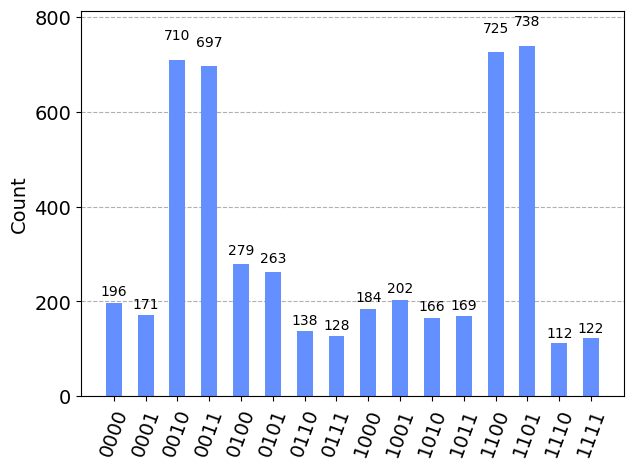

In [ ]:
# USER ENTRY
# increment and decrement circuit with coin flip for n-node loop
N = 16 # number of nodes
steps =12



n = int(np.ceil(np.log(N)/np.log(2))) # number of qubits needed to represent the nodes
qcoin = QuantumRegister(1, name='coin')
qposition = QuantumRegister(n, name='qposition')
cposition = ClassicalRegister(n, name='cposition')
qc= QuantumCircuit(qcoin, qposition, cposition)
qlist = [x for x in range(0, n+1)]

# custom gates for increment and decrement
qcinc = QuantumCircuit(n, name='increment')
listofcontrols = [x for x in range(0, n)]
for i in range(len(listofcontrols)):
  if listofcontrols == [0]:
    qcinc.x(0)
    break
  qcinc.mcx(listofcontrols[:-1], listofcontrols[-1])
  listofcontrols = listofcontrols[:-1]
increment = qcinc.to_gate().control(1)

qcdec = QuantumCircuit(n, name='decrement')
declistofcontrols = [x for x in range(0, n)]
for i in range(len(declistofcontrols)):
  for i in(declistofcontrols[:-1]):
    qcdec.x(i)
  if declistofcontrols == [0]:
    qcdec.x(0)
    break
  qcdec.mcx(declistofcontrols[:-1], declistofcontrols[-1])
  for i in(declistofcontrols[:-1]):
    qcdec.x(i)
  declistofcontrols = declistofcontrols[:-1]
decrement = qcdec.to_gate().control(1)
#

# Initialize coin state and first position
for i in range(1, n+1): # this creates balanced position state
   qc.h(i)
   qc.s(i)

qc.x(qposition[3]) # this puts us in the "middle" at |1000>

#qc.x(qcoin[0]) activate to flip coin state
#

for i in range(steps):
  # coin superposition
  qc.h(qcoin[0])
  qc.barrier()

  qc.append(increment, qlist)
  qc.barrier()

  qc.x(qcoin[0])
  qc.append(decrement, qlist) # controls on 0
  qc.x(qcoin[0])

  qc.barrier()

# measure position
for i in range(n):
  qc.measure(qposition[i], cposition[i])



backend = Aer.get_backend('qasm_simulator')
counts= execute(qc,backend, shots=5000).result().get_counts(qc)
print(counts)
plot_histogram(counts)
#qc.draw('mpl')

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


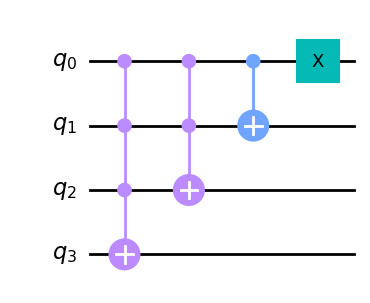

In [ ]:
qcinc.draw('mpl')

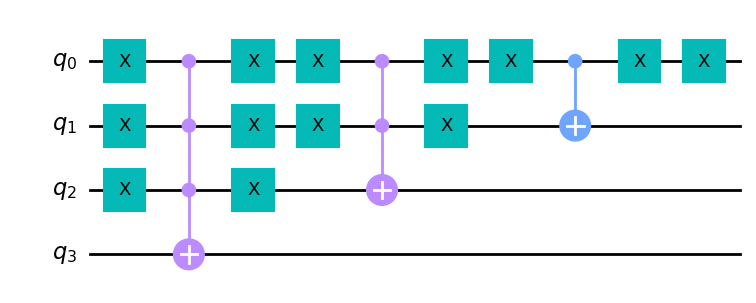

In [ ]:
qcdec.draw('mpl')

###Grover Coin

In [ ]:
# Custom Grover diffuser operator
qgrover = QuantumCircuit(2*n, name='Grover Walk')
grovercontrols = [x for x in range(n+1, 2*n)]
# grover coin
for i in range(n, 2*n):
  qgrover.h(i)
  qgrover.x(i)
  #qgrover.z(i)
qgrover.mcp(np.pi, grovercontrols, n)
for i in range(n, 2*n):
  qgrover.h(i)
  qgrover.x(i)

# swap gates
for i in range(n):
  qgrover.swap(i, n+i)

GroverWalk = qgrover.to_gate().control(1)
iGroverWalk = GroverWalk.inverse()

#qgrover.draw('mpl')

{'0000': 90, '0001': 79, '1011': 95, '0111': 1911, '0011': 68, '1111': 2000, '1110': 75, '1100': 76, '0101': 62, '1001': 72, '1000': 84, '0110': 90, '1101': 78, '0100': 66, '0010': 78, '1010': 76}


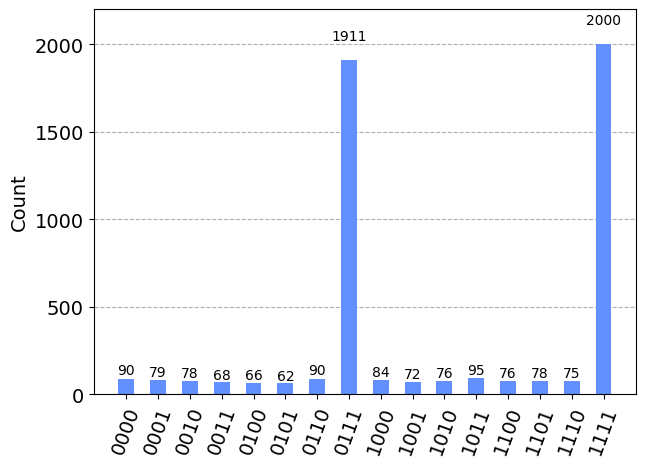

In [ ]:
# quick example just to show Grover coin by itself
qGro_no_alg = QuantumCircuit(8,4)
for i in range(4,8):
  qGro_no_alg.h(i)
qGro_no_alg.mcp(np.pi, [4,5], 6)
qGro_no_alg.append(qgrover, [0,1,2,3,4,5,6,7])
for i in range(4):
  qGro_no_alg.measure(i,i)

backend = Aer.get_backend('qasm_simulator')
counts= execute(qGro_no_alg,backend, shots=5000).result().get_counts(qGro_no_alg)
print(counts)
plot_histogram(counts)

#qGro_no_alg.draw('mpl')

{'0100': 110, '1110': 110, '1101': 95, '1100': 344, '0110': 397, '1000': 125, '1111': 1347, '0001': 112, '1001': 389, '0101': 387, '0000': 509, '0010': 104, '1011': 86, '0111': 110, '0011': 411, '1010': 364}


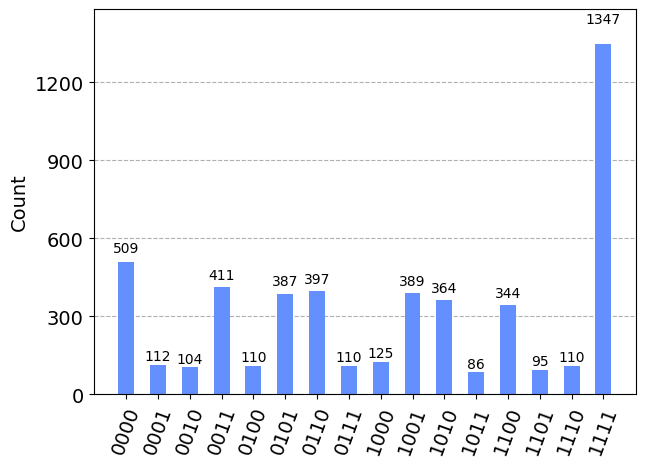

In [ ]:
# Quantum Walk Search Algorithm
n=4
thetabits=8

qtheta = QuantumRegister(thetabits, name='theta')
qnode = QuantumRegister(n, name='qNode')
cnode = ClassicalRegister(n, name='cNode')
qcoin = QuantumRegister(n, name='Coin')
qancilla = QuantumRegister(1, name='ancillary')
qc = QuantumCircuit(qtheta, qnode, qcoin, qancilla, cnode)

# first put node and coin in super position
for i in range(n):
  qc.h(qnode[i])
  qc.h(qcoin[i])
qc.barrier()

for i in range(4): #repeat 1/epsilon**0.5
  # oracle on |1111>
  qc.h(11)
  qc.mcx([8,9,10],11)
  qc.h(11)

  # phase estimation in fourier basis
  for i in range(thetabits):
    qc.h(qtheta[i])

  controlwalklist = [x for x in range(thetabits, thetabits+2*n)]
  for i in range(thetabits):
    qc.append(GroverWalk, [i]+controlwalklist)

  qc.barrier()
  myiQFT(qc,thetabits)

  qc.barrier()
  thetabitlist = [x for x in range(thetabits)]
  for i in range(thetabits):
    qc.x(i)
  qc.x(qancilla[0])
  qc.mcx(thetabitlist, qancilla[0])
  qc.z(qancilla[0])
  qc.mcx(thetabitlist, qancilla[0])
  for i in range(thetabits):
    qc.x(i)
  qc.x(qancilla[0])

  # reverse
  myQFT(qc,thetabits)

  for i in range(thetabits):
    qc.append(iGroverWalk, [thetabits-i-1]+controlwalklist)

  for i in range(thetabits):
    qc.h(qtheta[i])


# measure
for i in range(n):
  qc.measure(qnode[i], cnode[i])
backend = Aer.get_backend('qasm_simulator')
counts= execute(qc,backend, shots=5000).result().get_counts(qc)
print(counts)
plot_histogram(counts)


#qc.draw('mpl')

###Parton Showers

####1D Simple Shower

{'01': 1024}


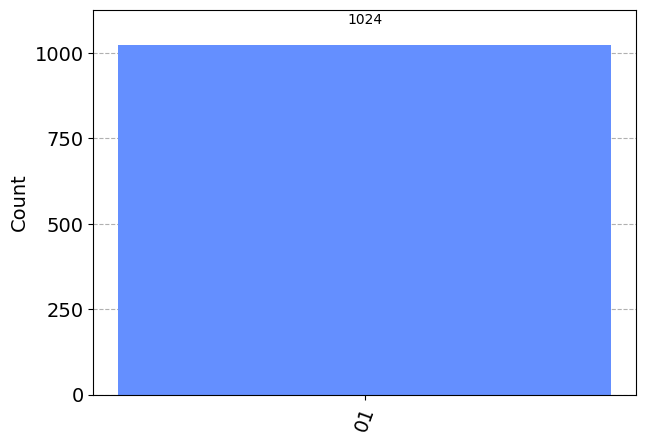

In [ ]:
nI = 2 # 2^nI is number of positions
prob= 0.999 # probability of emisson
steps = 5

# making the probability of emission matrix a gate (Sudakov factor)
quick=QuantumCircuit(1, name='P(Emit)')
probabilityofemission = Operator([[(1-prob)**0.5, -(prob)**0.5], [(prob)**0.5, (1-prob)**0.5]])
quick.append(probabilityofemission, [0])
probemitGATE = quick.to_gate().control(2)


position = QuantumRegister(nI, name='QPosition')
coin = QuantumRegister(1, name='Coin')
pos_check = QuantumRegister(1, name='Position Check')
memory = QuantumRegister(1, name='Memory')
cposition = ClassicalRegister(nI, name='CPosition')
qcparton = QuantumCircuit(position, coin, pos_check, memory, cposition)


for i in range(steps):
  qcparton.cx(coin[0], memory[0]) #only does something after second step, encodes
  # information about what the coin said
  qcparton.barrier()
  qcparton.mcx([position[0], position[1]], pos_check[0]) # check position for coin
  qcparton.barrier()
  qcparton.append(probemitGATE, [4,3,2])
  qcparton.barrier()
  qcparton.mcx([position[0], position[1]], pos_check[0]) # undoes position check
  qcparton.barrier()
  qcparton.mcx([2,1], 0)
  qcparton.mcx([2], 1)
  qcparton.barrier()
  qcparton.x(2)
  qcparton.x(1)
  qcparton.mcx([2,1], 0)
  qcparton.x(2)
  qcparton.x(1)
  qcparton.barrier()
  qcparton.x(1)
  qcparton.mcx([2], 1)
  qcparton.x(1)
  qcparton.barrier()


#quick.draw('mpl')


# measure
for i in range(2):
  qcparton.measure(position[i], cposition[i])
backend = Aer.get_backend('qasm_simulator')
counts= execute(qcparton,backend, shots=1024).result().get_counts(qcparton)
print(counts)
plot_histogram(counts)

#qcparton.draw('mpl')

####Collinear Parton Shower

{'0000': 1, '1010': 9, '1101': 1, '1001': 1, '1100': 302, '1110': 28, '0001': 154, '1111': 424, '0011': 104}


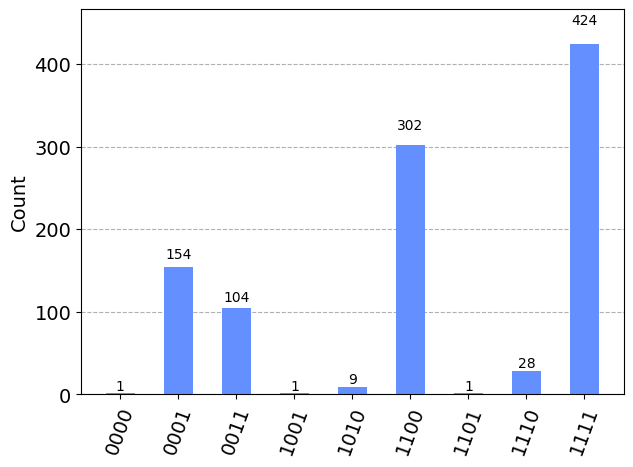

In [54]:
x = QuantumRegister(2, name='|x>')
y = QuantumRegister(2, name='|y>')
cps_coin = QuantumRegister(3, name='coin')
xy_check = QuantumRegister(3, name='position check')
cps_classical = ClassicalRegister(4, name='classical position')
qc_cps = QuantumCircuit(x,y,cps_coin,xy_check,cps_classical)


# initial state
qc_cps.x(0)
qc_cps.x(1)
qc_cps.x(2)
qc_cps.x(3)

# making each individual probability gate
p_qqbar = 0.9
p_gg = 0.9
p_qg = 0.9

qc_qqbar=QuantumCircuit(1, name='P(qqbar)')
op_qqbar = Operator([[(1-p_qqbar)**0.5, -(p_qqbar)**0.5], [(p_qqbar)**0.5, (1-p_qqbar)**0.5]])
qc_qqbar.append(op_qqbar, [0])
qqbarGATE = qc_qqbar.to_gate().control(1)

qc_gg=QuantumCircuit(1, name='P(gg)')
op_gg = Operator([[(1-p_gg)**0.5, -(p_gg)**0.5], [(p_gg)**0.5, (1-p_gg)**0.5]])
qc_gg.append(op_gg, [0])
ggGATE = qc_gg.to_gate().control(1)

qc_qg=QuantumCircuit(1, name='P(qg)')
op_qg = Operator([[(1-p_qg)**0.5, -(p_qg)**0.5], [(p_qg)**0.5, (1-p_qg)**0.5]])
qc_qg.append(op_qg, [0])
qgGATE = qc_qg.to_gate().control(1)
# end

for i in range(3):
  # qc_cps.x(0)
  # qc_cps.x(1)
  qc_cps.mcx([x[0], x[1]], xy_check[0])
  # qc_cps.x(0)
  # qc_cps.x(1)

  # qc_cps.x(2)
  # qc_cps.x(3)
  qc_cps.mcx([y[0], y[1]], xy_check[1])
  # qc_cps.x(2)
  # qc_cps.x(3)


  qc_cps.mcx([xy_check[0], xy_check[1]], xy_check[2])

  qc_cps.append(qqbarGATE, [9,4])
  qc_cps.append(ggGATE, [9,5])
  qc_cps.append(qgGATE, [9,6])
  qc_cps.barrier()

  # g --> qqbar
  qc_cps.x(1)
  qc_cps.x(5)
  qc_cps.x(6)
  qc_cps.mcx([4,5,6,1],0)
  qc_cps.x(1)
  qc_cps.x(5)
  qc_cps.x(6)
  qc_cps.barrier()

  qc_cps.x(5)
  qc_cps.x(6)
  qc_cps.mcx([4,5,6],1)
  qc_cps.x(5)
  qc_cps.x(6)
  qc_cps.barrier()

  qc_cps.x(5)
  qc_cps.x(6)
  qc_cps.mcx([3,4,5,6],2)
  qc_cps.x(5)
  qc_cps.x(6)
  qc_cps.barrier()

  qc_cps.x(5)
  qc_cps.x(6)
  qc_cps.mcx([4,5,6],3)
  qc_cps.x(5)
  qc_cps.x(6)
  qc_cps.barrier()

  # g --> gg
  qc_cps.x(4)
  qc_cps.x(6)
  qc_cps.mcx([1,4,5,6],0)
  qc_cps.x(4)
  qc_cps.x(6)
  qc_cps.barrier()

  qc_cps.x(4)
  qc_cps.x(6)
  qc_cps.mcx([4,5,6],1)
  qc_cps.x(4)
  qc_cps.x(6)
  qc_cps.barrier()

  # q --> qg
  qc_cps.x(4)
  qc_cps.x(5)
  qc_cps.mcx([1,4,5,6],0)
  qc_cps.x(4)
  qc_cps.x(5)
  qc_cps.barrier()

  qc_cps.x(4)
  qc_cps.x(5)
  qc_cps.mcx([4,5,6],1)
  qc_cps.x(4)
  qc_cps.x(5)
  qc_cps.barrier()

# measure
for i in range(4):
  qc_cps.measure(i, cps_classical[i])
backend = Aer.get_backend('qasm_simulator')
counts= execute(qc_cps,backend, shots=1024).result().get_counts(qc_cps)
print(counts)
plot_histogram(counts)

#qc_cps.draw('mpl')